In [1]:
# IMPORTS AND NOTEBOOK SETUP
from SimpleCV import *
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

%matplotlib inline

# Config: size of the figures
matplotlib.rcParams['figure.figsize'] = [10, 6]

disp = Display(displaytype='notebook')

In [2]:
# HELPER METHODS
SIZE = 32

def get_individual_images(img):
    return [
        (int(img[0][0]), img[1].crop(SIZE * 0, 0, SIZE, SIZE)),
        (int(img[0][1]), img[1].crop(SIZE * 1, 0, SIZE, SIZE)),
        (int(img[0][2]), img[1].crop(SIZE * 2, 0, SIZE, SIZE)),
        (int(img[0][3]), img[1].crop(SIZE * 3, 0, SIZE, SIZE))
    ]

def get_images_in_path(path):
    img_list = []
    for name in os.listdir(path):
        if name.endswith('.png'):
            img = Image(os.path.join(path, name))
            label = name[:-4]
            img_list.append((label, img))
    return img_list

def get_weighted_matrix(img):
    COUNT = 4
    CROP = SIZE / COUNT
    m = np.zeros((COUNT, COUNT))
    for y in range(COUNT):
        for x in range(COUNT):
            color = img.crop(x * CROP, y * CROP, CROP, CROP).meanColor()
            m[x][y] = 0 if color[0] < 80 else 1
    return m.T

In [3]:
# IMAGE PRE-PROCESSING
images = get_images_in_path('../dataset-images/')
images_soft = []
for img in images:
    images_soft.append(
        (img[0], img[1].binarize()
                        .dilate()
                        .erode())
    )

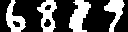

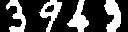

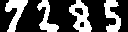

In [4]:
# EXAMPLE IMAGES
images_soft[0][1].save(disp)
images_soft[1][1].save(disp)
images_soft[2][1].save(disp)

In [5]:
# EXTRACTING INDIVIDUAL DIGITS
digits = []
for img in images_soft:
    digits.extend(get_individual_images(img))

# digits = sorted(digits)

/usr/local/lib/python2.7/dist-packages/SimpleCV/ImageClass.py:1970: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._numpy != "":


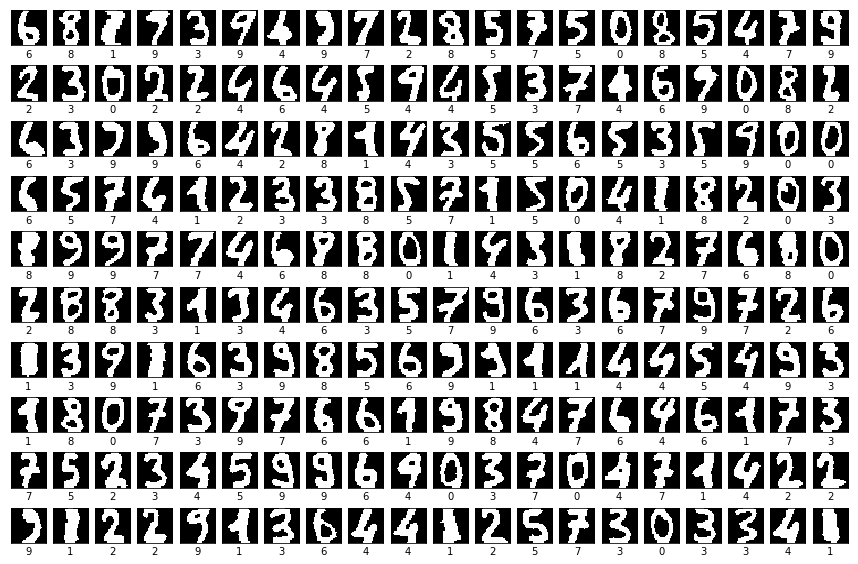

In [6]:
# PLOTTING IMAGES AND THEIR LABELS
PLOT_SIZE = 200
ROW_WIDTH = 20
plt.figure(figsize=(15, PLOT_SIZE / ROW_WIDTH))
for i in range(PLOT_SIZE):
    plt.subplot(PLOT_SIZE / ROW_WIDTH, ROW_WIDTH, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.xlabel(digits[i][0])
    plt.imshow(digits[i][1].getNumpy(), cmap=plt.cm.binary)

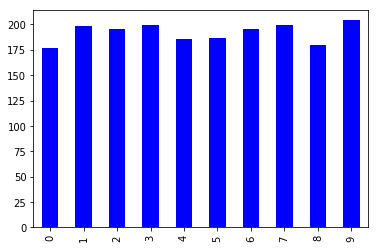

In [7]:
# CREATE DATAFRAME FROM DIGITS
data = pd.DataFrame(digits, columns=['digit', 'image'])
data_sorted = pd.DataFrame(sorted(digits), columns=['digit', 'image'])

# PLOT INTERESTING FEATURES
digit_counts = data.digit.value_counts()
digit_counts.sort_index(inplace=True)
digit_counts.plot(kind='bar')

[[ 0.  1.  1.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  1.  1.  0.]
 [ 0.  1.  1.  0.]]
5


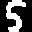

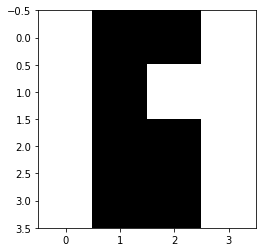

In [8]:
# TESTING WEIGHTED MATRIX CREATION
img = data_sorted.image[1100]
m = get_weighted_matrix(img)
print m
print data_sorted.digit[1100]
img.save(disp)
plt.imshow(m, cmap='Greys', interpolation='nearest')
plt.show()

In [9]:
# EXTRACTING FEATURES AND SAVING TO CSV
features_dict = {
    "area": [],
    "contours": [],
    "radius": [],
    "circle_dist": [],
    "rect_dist": [],
    "hull_radius": [],
    "aspect_ratio": [],
    "centroid_x": [],
    "centroid_y": [],
    "angle": [],
    "column_weight_1": [],
    "column_weight_2": [],
    "column_weight_3": [],
    "column_weight_4": [],
    "row_weight_1": [],
    "row_weight_2": [],
    "row_weight_3": [],
    "row_weight_4": [],
    "label": []
}

for row in data_sorted.iterrows():
    digit = row[1]
    digit[1].show()
    blobs = digit[1].findBlobs()
    if blobs:
        blob = blobs[0]
        features_dict['area'].append(blob.area())
        features_dict['contours'].append(len(blob.contour()))
        features_dict['circle_dist'].append(blob.circleDistance())
        features_dict['rect_dist'].append(blob.rectangleDistance())
        features_dict['radius'].append(blob.radius())
        features_dict['hull_radius'].append(blob.hullRadius())
        features_dict['aspect_ratio'].append(blob.aspectRatio())
        features_dict['centroid_x'].append(blob.centroid()[0])
        features_dict['centroid_y'].append(blob.centroid()[1])
        features_dict['angle'].append(blob.angle())
    
    m = get_weighted_matrix(digit[1])
    features_dict['column_weight_1'].append(np.sum(m[:,0]))
    features_dict['column_weight_2'].append(np.sum(m[:,1]))
    features_dict['column_weight_3'].append(np.sum(m[:,2]))
    features_dict['column_weight_4'].append(np.sum(m[:,3]))
    features_dict['row_weight_1'].append(np.sum(m[0,:]))
    features_dict['row_weight_2'].append(np.sum(m[1,:]))
    features_dict['row_weight_3'].append(np.sum(m[2,:]))
    features_dict['row_weight_4'].append(np.sum(m[3,:]))
    
    features_dict['label'].append(digit[0])

# Create dataframe
data_frame = pd.DataFrame(features_dict)
# Reorder columns
data_frame = data_frame[[
    "area",
    "contours",
    "radius",
    "circle_dist",
    "rect_dist",
    "hull_radius",
    "aspect_ratio",
    "centroid_x",
    "centroid_y",
    "angle",
    "column_weight_1",
    "column_weight_2",
    "column_weight_3",
    "column_weight_4",
    "row_weight_1",
    "row_weight_2",
    "row_weight_3",
    "row_weight_4",
    "label"
]]

# Save to CSV file
data_frame.to_csv('../dataset-numpy/dataset.csv', sep=',', encoding='utf-8')